In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --quiet transformers==4.1.1
!pip install --quiet tokenizers==0.9.4 
!pip install --quiet sentencepiece==0.1.94
!pip install --quiet tqdm==4.56.0
!pip install --quiet pytorch-lightning==1.2.10
!pip install --quiet gradio

     |████████████████████████████████| 1.5 MB 5.5 MB/s 
     |████████████████████████████████| 2.9 MB 35.5 MB/s 
     |████████████████████████████████| 895 kB 46.0 MB/s 
     |████████████████████████████████| 1.1 MB 5.5 MB/s 
     |████████████████████████████████| 72 kB 812 kB/s 
     |████████████████████████████████| 841 kB 5.3 MB/s 
     |████████████████████████████████| 829 kB 13.4 MB/s 
     |████████████████████████████████| 596 kB 43.6 MB/s 
     |████████████████████████████████| 132 kB 45.8 MB/s 
     |████████████████████████████████| 176 kB 47.1 MB/s 
     |████████████████████████████████| 1.1 MB 35.8 MB/s 
     |████████████████████████████████| 192 kB 43.8 MB/s 
     |████████████████████████████████| 271 kB 44.4 MB/s 
     |████████████████████████████████| 160 kB 47.4 MB/s 
     |████████████████████████████████| 865 kB 5.5 MB/s 
     |████████████████████████████████| 210 kB 45.7 MB/s 
     |████████████████████████████████| 2.0 MB 25.3 MB/s 
     |██████████████

In [ ]:
#Restart Runtime

In [ ]:
%cd /content/drive/My Drive/Text Mining TDDE16/

/content/drive/My Drive/Text Mining TDDE16


In [ ]:
import argparse
import os
import json
import time
import logging
import random
import re

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

pl.seed_everything(100)

Global seed set to 100


100

In [ ]:
train_df = pd.read_csv('dataset/squad_train.csv', nrows=10000)
train_df.shape

(10000, 3)

In [ ]:
train_df.head()

,context,answer,question
0,Beyoncé's lighter skin color and costuming has...,L'Oréal,Which company was accused of coloring Beyonce'...
1,Democratic Party candidates were consistently ...,120,About how many people died during the Draft Ri...
2,"In South Africa, a ""two apex"" system existed f...",the Constitutional Court,What court in South Africa has authority over ...
3,The University of Notre Dame has made being a ...,40%,What percentage of the food served at Notre Da...
4,Federalism is one of the entrenched constituti...,the federation,"In Germany, foreign affairs is under the exclu..."


In [ ]:
valid_df = pd.read_csv('dataset/squad_val.csv', nrows=1000)
valid_df.shape

(1000, 3)

In [ ]:
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base')

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Some weights of the model checkpoint at t5-base were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Dataset Loader

In [ ]:
from tqdm.notebook import tqdm
import copy

class QuestionGenerationDataset(Dataset):
    def __init__(self, tokenizer, data, max_len_inp=512,max_len_out=96):

        self.passage = "context"
        self.answer = "answer"
        self.question = "question"

        self.data = data

        self.max_len_input = max_len_inp
        self.max_len_output = max_len_out
        self.tokenizer = tokenizer
        self.inputs = []
        self.targets = []

        self._build()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()
        target_ids = self.targets[index]["input_ids"].squeeze()

        src_mask = self.inputs[index]["attention_mask"].squeeze()
        target_mask = self.targets[index]["attention_mask"].squeeze()

        labels = copy.deepcopy(target_ids)
        labels [labels==0] = -100

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask,"labels":labels}

    def _build(self):
        for idx in tqdm(range(len(self.data))):
            passage, answer, target = self.data.loc[idx, self.passage], self.data.loc[idx, self.answer], self.data.loc[idx, self.question]

            input_ = "context: %s  answer: %s </s>" % (passage, answer)
            target = "question: %s </s>" % (str(target))

            # get encoding length of input. If it is greater than self.max_len skip it
            test_input_encoding = self.tokenizer.encode_plus(input_, truncation=False, return_tensors="pt")
            
            length_of_input_encoding = len(test_input_encoding['input_ids'][0])

            if length_of_input_encoding > self.max_len_input:
              continue

            # tokenize inputs
            tokenized_inputs = self.tokenizer.batch_encode_plus(
                [input_], max_length=self.max_len_input, pad_to_max_length=True, return_tensors="pt")
            
            # tokenize targets
            tokenized_targets = self.tokenizer.batch_encode_plus(
                [target], max_length=self.max_len_output, pad_to_max_length=True,return_tensors="pt")

            self.inputs.append(tokenized_inputs)
            self.targets.append(tokenized_targets)


In [ ]:
train_dataset = QuestionGenerationDataset(t5_tokenizer, train_df)

  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:184: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padd

In [ ]:
validation_dataset = QuestionGenerationDataset(t5_tokenizer, valid_df)


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:184: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Fine Tune

In [ ]:
class T5FineTuner(pl.LightningModule):
    def __init__(self,hparams, t5model, t5tokenizer):
        super(T5FineTuner, self).__init__()
        self.hparams = hparams
        self.model = t5model
        self.tokenizer = t5tokenizer


    def forward( self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None):
         outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,)
         
         return outputs


    def training_step(self, batch, batch_idx):
        outputs = self.forward(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            decoder_input_ids = batch["target_ids"],
            decoder_attention_mask=batch['target_mask'],
            lm_labels=batch['labels'])

        loss = outputs[0]
        self.log('train_loss',loss)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.forward(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            decoder_input_ids = batch["target_ids"],
            decoder_attention_mask=batch['target_mask'],
            lm_labels=batch['labels'])

        loss = outputs[0]
        self.log("val_loss",loss)
        return loss

    def train_dataloader(self):
        return DataLoader(train_dataset, batch_size=self.hparams.batch_size,num_workers=4)

    def val_dataloader(self):
        return DataLoader(validation_dataset, batch_size=self.hparams.batch_size,num_workers=4)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=3e-4, eps=1e-8)
        return optimizer


In [ ]:
args_dict = dict(
    batch_size=4,
)

args = argparse.Namespace(**args_dict)


model = T5FineTuner(args, t5_model, t5_tokenizer)

trainer = pl.Trainer(max_epochs = 3, gpus=1, progress_bar_refresh_rate=30)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [ ]:
print ("Saving model")

save_path_model = '/content/drive/My Drive/Text Mining TDDE16/t5/model/'
save_path_tokenizer = '/content/drive/My Drive/Text Mining TDDE16/t5/tokenizer/'
model.model.save_pretrained(save_path_model)
t5_tokenizer.save_pretrained(save_path_tokenizer)

Saving model


('/content/drive/My Drive/Text Mining TDDE16/t5/tokenizer/tokenizer_config.json',
 '/content/drive/My Drive/Text Mining TDDE16/t5/tokenizer/special_tokens_map.json',
 '/content/drive/My Drive/Text Mining TDDE16/t5/tokenizer/spiece.model',
 '/content/drive/My Drive/Text Mining TDDE16/t5/tokenizer/added_tokens.json')

In [ ]:
# Testing

## Test the model

In [ ]:
trained_model_path = '/content/drive/My Drive/Text Mining TDDE16/t5/model/'
trained_tokenizer = '/content/drive/My Drive/Text Mining TDDE16/t5/tokenizer/'

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(trained_model_path)
tokenizer = T5Tokenizer.from_pretrained(trained_tokenizer)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ("device ",device)

model = model.to(device)

device  cuda


In [ ]:
context = "President Joe Biden said and predicted that some states would reopen this month."
answer = "Joe Biden"
ques = "Who said that some states would reopen this month?"
text = "context: "+context + " " + "answer: " + answer + " </s>"
print (text)

context: President Joe Biden said and predicted that some states would reopen this month. answer: Joe Biden </s>


In [ ]:
train_df.iloc[8]['context'], train_df.iloc[8]['answer'], train_df.iloc[8]['question']

('The Mass of Paul VI was also in Latin but approval was given for the use of vernacular languages. There had been other instructions issued by the Pope in 1964, 1967, 1968, 1969 and 1970 which centered on the reform of all liturgies of the Roman Church. These major reforms were not welcomed by all and in all countries. The sudden apparent "outlawing" of the 400-year-old Mass, the last typical edition of which being promulgated only a few years earlier in 1962 by Paul\'s predecessor, Pope John XXIII, was not always explained well. Further experimentation with the new Mass by liturgists, such as the usage of pop/folk music (as opposed to the Gregorian Chant advocated by Pope Pius X), along with concurrent changes in the order of sanctuaries, was viewed by some as vandalism. In 2007, Pope Benedict XVI clarified that the 1962 Mass of John XXIII and the 1970 Mass of Paul VI are two forms of the same Roman Rite, the first, which had never been "juridically abrogated", now being an "extraord

In [ ]:
context = train_df.iloc[8]['context']
answer = train_df.iloc[8]['answer']
ques = train_df.iloc[8]['question']
text = "context: "+context + " " + "answer: " + answer + " </s>"
print (text)

context: The Mass of Paul VI was also in Latin but approval was given for the use of vernacular languages. There had been other instructions issued by the Pope in 1964, 1967, 1968, 1969 and 1970 which centered on the reform of all liturgies of the Roman Church. These major reforms were not welcomed by all and in all countries. The sudden apparent "outlawing" of the 400-year-old Mass, the last typical edition of which being promulgated only a few years earlier in 1962 by Paul's predecessor, Pope John XXIII, was not always explained well. Further experimentation with the new Mass by liturgists, such as the usage of pop/folk music (as opposed to the Gregorian Chant advocated by Pope Pius X), along with concurrent changes in the order of sanctuaries, was viewed by some as vandalism. In 2007, Pope Benedict XVI clarified that the 1962 Mass of John XXIII and the 1970 Mass of Paul VI are two forms of the same Roman Rite, the first, which had never been "juridically abrogated", now being an "ex

In [ ]:
encoding = tokenizer.encode_plus(text, max_length =512, padding=True, return_tensors="pt")

input_ids, attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:184: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


In [ ]:
encoding = tokenizer.encode_plus('question: '+ ques, max_length = 96, padding=True, return_tensors="pt")

target_ids, target_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

In [ ]:
import copy

In [ ]:
labels = copy.deepcopy(target_ids)
labels [labels==0] = -100

In [ ]:
# Last hidden state or output

model(input_ids=input_ids, attention_mask=attention_mask, decoder_attention_mask=target_mask, 
      labels=labels)[1].shape

torch.Size([1, 15, 32128])

In [ ]:
# Att Weights 

model(input_ids=input_ids, attention_mask=attention_mask, decoder_attention_mask=target_mask, 
      labels=labels)[2][0][0].shape

torch.Size([1, 12, 15, 64])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'svg'

plt.style.use('seaborn')

In [ ]:
model.eval()

beam_outputs = model.generate(
    input_ids=input_ids, attention_mask=attention_mask,
    max_length=72,
    early_stopping=True,
    num_beams=5,
    num_return_sequences=3
)

for beam_output in beam_outputs:
    sent = tokenizer.decode(beam_output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    print (sent)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1065: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


question: How old was Paul VI's Mass?
question: How old was Paul VI's last mass?
question: How old was Paul VI's last published Mass?


In [ ]:
print('True: ', ques)

True:  How old was the mass reformed by Paul VI?


In [ ]:
train_df.iloc[8]['context']

'The Mass of Paul VI was also in Latin but approval was given for the use of vernacular languages. There had been other instructions issued by the Pope in 1964, 1967, 1968, 1969 and 1970 which centered on the reform of all liturgies of the Roman Church. These major reforms were not welcomed by all and in all countries. The sudden apparent "outlawing" of the 400-year-old Mass, the last typical edition of which being promulgated only a few years earlier in 1962 by Paul\'s predecessor, Pope John XXIII, was not always explained well. Further experimentation with the new Mass by liturgists, such as the usage of pop/folk music (as opposed to the Gregorian Chant advocated by Pope Pius X), along with concurrent changes in the order of sanctuaries, was viewed by some as vandalism. In 2007, Pope Benedict XVI clarified that the 1962 Mass of John XXIII and the 1970 Mass of Paul VI are two forms of the same Roman Rite, the first, which had never been "juridically abrogated", now being an "extraordi

In [ ]:
train_df.iloc[8]['answer']

'400-year'

In [ ]:
model.eval()

beam_outputs = model.generate(
    input_ids=input_ids, attention_mask=attention_mask,
    max_length=72,
    early_stopping=True,
    num_beams=5,
    num_return_sequences=3
)

for beam_output in beam_outputs:
    sent = tokenizer.decode(beam_output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    print (sent)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1065: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


question: Who predicted that some states would reopen this month?
question: Who said that some states would reopen this month?
question: Which president predicted that some states would reopen this month?


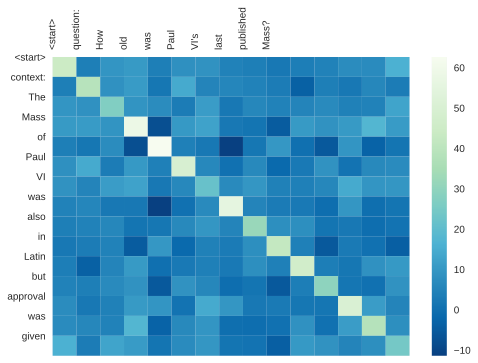

In [ ]:

attention = model(input_ids=input_ids, attention_mask=attention_mask, decoder_attention_mask=target_mask, 
                  labels=labels)[2][0][0]

attention = torch.squeeze(attention, 0)

attention = attention.cpu().detach().numpy()
attention = attention[0]

att = np.matmul(attention, np.transpose(attention))

fig, ax = plt.subplots()
heatmap = ax.pcolor(att, cmap='GnBu_r')

L = ['<start>']
ax.set_xticklabels(L+sent.split(), rotation='vertical')
ax.set_yticklabels(L+text.split())

ax.xaxis.tick_top()
ax.set_xticks(np.arange(att.shape[1]))
ax.set_yticks(np.arange(att.shape[0]))
ax.invert_yaxis()

plt.colorbar(heatmap)

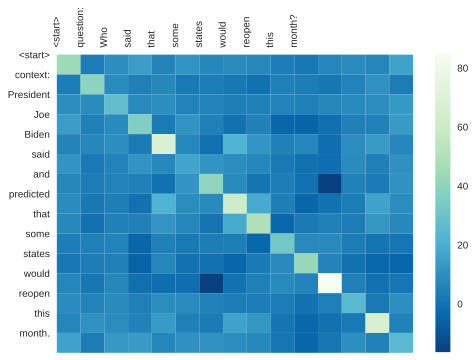

In [ ]:
# 2
attention = model(input_ids=input_ids, attention_mask=attention_mask, decoder_attention_mask=target_mask, 
                  labels=labels)[2][0][0]

attention = torch.squeeze(attention, 0)

attention = attention.cpu().detach().numpy()
attention = attention[0]

att = np.matmul(attention, np.transpose(attention))

fig, ax = plt.subplots()
heatmap = ax.pcolor(att, cmap='GnBu_r')

L = ['<start>']
ax.set_xticklabels(L+['question:']+ques.split(), rotation='vertical')
ax.set_yticklabels(L+text.split())

ax.xaxis.tick_top()
ax.set_xticks(np.arange(att.shape[1]))
ax.set_yticks(np.arange(att.shape[0]))
ax.invert_yaxis()

plt.colorbar(heatmap)

## Evaluation Metrics

In [ ]:
test_df = pd.read_csv('dataset/squad_test.csv', nrows=1000)
test_df.shape

(1000, 3)

In [ ]:
test_df.head()

,context,answer,question
0,Guinea-Bissau was once part of the kingdom of ...,political instability,Guinea-Bissau has a history of what since inde...
1,The quarter-wave elements imitate a series-res...,lossless,What could be the best possible output versus ...
2,New York City's commuter rail network is the l...,Manhattan,In what borough is Pennsylvania Station located?
3,"The end of a treaty, the eschatocol (or closin...",equally authentic,What is the nature of the different versions o...
4,The modern petroleum industry started in 1846 ...,Bóbrka,Where was the first Rock Oil mine built?


In [ ]:
def generate_question(i):

  context = test_df.iloc[i]['context']
  answer = test_df.iloc[i]['answer']
  text = "context: "+ context + " " + "answer: " + answer + " </s>"

  encoding = tokenizer.encode_plus(text, max_length =512, padding=True, return_tensors="pt")

  input_ids, attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

  beam_outputs = model.generate(
      input_ids=input_ids, attention_mask=attention_mask,
      max_length=72,
      early_stopping=True,
      num_beams=5,
      num_return_sequences=3)

  sent = tokenizer.decode(beam_outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
  return sent

In [ ]:
# test_pred = [generate_question(i) for i in range(len(test_df))]

In [ ]:
# test_pred_new = []
# for t in test_pred:
#   r = re.search('question:(.*)', t)
#   test_pred_new.append(r.group(1).strip())

In [ ]:
# pred_df = pd.DataFrame(test_pred_new, columns=['prediction'])
# pred_df.head()

,prediction
0,What has Guinea-Bissau experienced since indep...
1,What type of series-resonant circuit is ideal?
2,The busiest station in New York is on the West...
3,"If a treaty is executed in multiple languages,..."
4,Where was the first rock oil mine built?


In [ ]:
# pred_save_path = '/content/drive/My Drive/Text Mining TDDE16/dataset/test_pred.csv'

# pred_df.to_csv(pred_save_path, index = False)

In [ ]:
pred_df = pd.read_csv('dataset/test_pred.csv')
pred_df['true'] = test_df['question']
pred_df['text'] = test_df['context']
pred_df['ans'] = test_df['answer']
pred_df.head()

,prediction,true,text,ans
0,What has Guinea-Bissau experienced since indep...,Guinea-Bissau has a history of what since inde...,Guinea-Bissau was once part of the kingdom of ...,political instability
1,What type of series-resonant circuit is ideal?,What could be the best possible output versus ...,The quarter-wave elements imitate a series-res...,lossless
2,The busiest station in New York is on the West...,In what borough is Pennsylvania Station located?,New York City's commuter rail network is the l...,Manhattan
3,"If a treaty is executed in multiple languages,...",What is the nature of the different versions o...,"The end of a treaty, the eschatocol (or closin...",equally authentic
4,Where was the first rock oil mine built?,Where was the first Rock Oil mine built?,The modern petroleum industry started in 1846 ...,Bóbrka


In [ ]:
#Exact Match Acc

In [ ]:
acc = 0
for i in range(len(test_df)):
  if test_df.iloc[i]['question'].lower() == pred_df.iloc[i]['prediction'].lower():
    acc += 1

print(acc/len(test_df))

0.034


In [ ]:
#Precision and F1 score

In [ ]:
precision = []
recall = []
f1 = []

for i in range(len(test_df)):
  gold = set(test_df.iloc[i]['question'].lower().split())
  pred = set(pred_df.iloc[i]['prediction'].lower().split())

  p = len(gold & pred)/len(pred)
  precision.append(p)
  rc = len(gold & pred)/len(gold)
  recall.append(rc)

  if p + rc == 0:
    f1.append(0.0)
    continue
  f1.append(2 * (p * rc) / (p + rc))

print('Precision score: ', sum(precision)/len(test_df))
print('Recall score: ', sum(recall)/len(test_df))
print('F1 Score: ', sum(f1)/len(test_df))

Precision score:  0.46476315456988804
Recall score:  0.43674844411320723
F1 Score:  0.43965639361310904


In [ ]:
#Semantic preserved similarity

In [ ]:
from transformers import BertTokenizer, BertForQuestionAnswering

btokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bmodel = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [ ]:
def answer_question(question, answer_text):

    input_ids = btokenizer.encode(question, answer_text)

    sep_index = input_ids.index(btokenizer.sep_token_id)

    num_seg_a = sep_index + 1

    num_seg_b = len(input_ids) - num_seg_a

    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    assert len(segment_ids) == len(input_ids)

    outputs = bmodel(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits
    
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    tokens = btokenizer.convert_ids_to_tokens(input_ids)

    answer = tokens[answer_start]

    for i in range(answer_start + 1, answer_end + 1):
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        else:
            answer += ' ' + tokens[i]

    return 'Answer: "' + answer + '"'

In [ ]:
question, text = pred_df.iloc[8]['true'], pred_df.iloc[8]['text']
print(answer_question(question, text))
question, text = pred_df.iloc[8]['prediction'], pred_df.iloc[8]['text']
print(answer_question(question, text))

Answer: "compaq , gateway , ibm , packard bell , and ast research struggled and eventually left the market or were bought out . dell surpassed compaq to become the largest pc manufacturer in 1999 . operating costs made up only 10 percent of dell"
Answer: "compaq , gateway , ibm , packard bell , and ast research struggled and eventually left the market or were bought out . dell surpassed compaq to become the largest pc manufacturer in 1999 . operating costs made up only 10 percent of dell"


In [ ]:
pred_df.iloc[8]['ans']

'steady growth'

In [ ]:
# SPS Score

In [ ]:
acc = []

for i in range(len(pred_df)):
  q1, t = pred_df.iloc[i]['true'], pred_df.iloc[i]['text']
  q2 = pred_df.iloc[i]['prediction']

  if len(t) > 2000:
    continue
  if answer_question(q1, t) == answer_question(q2, t):
    acc.append(1)
  else:
    acc.append(0)

In [ ]:
print('SPS score: ', sum(acc) / len(acc))

SPS score:  0.5800604229607251


## Generating Distractors

In [ ]:
# Use NER to extract important entities as answers from context

In [ ]:
import spacy

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
def get_entity(doc):
  ner = []
  if doc.ents:
    for ent in doc.ents:
      ner.append(ent.text)
  else:
    print('No entities found!')
  
  return random.choice(ner)

In [ ]:
get_entity(nlp(test_df.iloc[0]['context']))

'the Mali Empire'

In [ ]:
from textblob import TextBlob
import nltk

nltk.download('brown')
nltk.download('punkt')

nltk.download('wordnet')
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
blob = TextBlob(context)
answer = random.choice(blob.noun_phrases)

In [ ]:
blob.noun_phrases

WordList(['donald trump'])

In [ ]:
#Using wornet find similar words as the given answer

In [ ]:
get_entity(nlp(test_df.iloc[0]['context']))

'Portuguese Guinea'

In [ ]:
blob = TextBlob('Portuguese Guinea')
random.choice(blob.noun_phrases)

'guinea'

In [ ]:
word = "guinea"
word = word.lower()
syns = wn.synsets(word)

for syn in syns:
  print (syn, ": ",syn.definition(),"\n" )

Synset('guinea.n.01') :  a former British gold coin worth 21 shillings 

Synset('wop.n.01') :  (ethnic slur) offensive term for a person of Italian descent 

Synset('guinea.n.03') :  a republic in western Africa on the Atlantic; formerly a French colony; achieved independence from France in 1958 

Synset('guinea_fowl.n.01') :  a west African bird having dark plumage mottled with white; native to Africa but raised for food in many parts of the world 



In [ ]:
# Get hypernyms for a synset

word = "portuguese"
word = word.lower()
syns = wn.synsets(word,'n')


hypernym = syns[0].hypernyms()
print (hypernym)
print (hypernym[0].hyponyms())

[Synset('romance.n.03')]
[Synset('catalan.n.02'), Synset('french.n.01'), Synset('galician.n.01'), Synset('haitian_creole.n.01'), Synset('italian.n.02'), Synset('portuguese.n.01'), Synset('rhaeto-romance.n.01'), Synset('romanian.n.02'), Synset('spanish.n.01')]


In [ ]:
# Wrong choice or distractors

for w in hypernym[0].hyponyms():
  print(w.lemma_names()[0])

Catalan
French
Galician
Haitian_Creole
Italian
Portuguese
Rhaeto-Romance
Romanian
Spanish


In [ ]:
doc = nlp('President Donald Trump said and predicted that some states would reopen this month.')

for token in doc:
  print(token.text, token.pos_)

President PROPN
Donald PROPN
Trump PROPN
said VERB
and CCONJ
predicted VERB
that SCONJ
some DET
states NOUN
would VERB
reopen VERB
this DET
month NOUN
. PUNCT


In [ ]:
def get_answers(text, pos):
  w = [' ', ' ', ' ']

  doc = nlp(text)
  flag = 0

  for token in doc:
    if token.pos_ == pos:
      word = token.text
      word = word.lower()
      syns = wn.synsets(word)
      if syns:
        hypernym = syns[0].hypernyms()
        for i,t in enumerate(hypernym[0].hyponyms()):
          w[i] = t.lemma_names()[0]
          if i == 2:
            break
        if i == 2:
          break
  return w[0], w[1], w[2]

In [ ]:
ans = 'Donald Trump'.replace(' ','_')
doc = nlp(ans)
for token in doc:
  if token.pos_ == 'PROPN':
    pos = 'PROPN'
  elif token.pos_ == 'VERB':
    pos = 'VERB'
  elif token.pos_ == 'NOUN':
    pos = 'NOUN'

pos

'PROPN'

In [ ]:
get_answers('President Donald Trump said and predicted that some states would reopen this month.', pos)

('chairman_of_the_board', 'chief_executive_officer', 'chief_financial_officer')

In [ ]:
# If ans is noun select noun from spacy!
# If ans is verb select noun from spacy!
# If ans is propnoun select propnoun from spacy!

In [ ]:
def get_result(text):

  answer = get_entity(nlp(text))

  ans = answer.replace(' ','_')
  doc = nlp(ans)
  pos = 'NOUN'

  for token in doc:
    if token.pos_ == 'PROPN':
      pos = 'PROPN'
    elif token.pos_ == 'VERB':
      pos = 'VERB'
    elif token.pos_ == 'NOUN':
      pos = 'NOUN'

  w1, w2, w3 = get_answers(text, pos)

  full = "context: "+ text + " " + "answer: " + answer + " </s>"

  encoding = tokenizer.encode_plus(full, max_length =512, padding=True, return_tensors="pt")

  input_ids, attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

  beam_outputs = model.generate(
      input_ids=input_ids, attention_mask=attention_mask,
      max_length=72,
      early_stopping=True,
      num_beams=5,
      num_return_sequences=3)

  sent = tokenizer.decode(beam_outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
  return sent, answer, w1, w2, w3

In [ ]:
def get_hypos(ques):
  w1 = ' '
  w2 = ' '
  w3 = ' '
  r = re.search('question:(.*)', ques)
  doc = nlp(r.group(1).strip())
  nn = []
  for token in doc:
    if token.pos_ == 'NOUN':
      nn.append(token.lemma_)

  sel_rand = random.choice(nn)

  hypo = wn.synsets(sel_rand, 'n')
  hypos = list(set([w for s in hypo[0].closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))

  if len(hypos) >=3:
    w1 = hypos[0]
    w2 = hypos[1]
    w3 = hypos[2]
  
  return w1, w2, w3

In [ ]:
get_hypos('question: What country did John use as a base for operations?')

('running', 'idle', 'commission')

In [ ]:
def get_new_result(text):

  answer = get_entity(nlp(text))

  full = "context: "+ text + " " + "answer: " + answer + " </s>"

  encoding = tokenizer.encode_plus(full, max_length =512, padding=True, return_tensors="pt")

  input_ids, attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

  beam_outputs = model.generate(
      input_ids=input_ids, attention_mask=attention_mask,
      max_length=72,
      early_stopping=True,
      num_beams=5,
      num_return_sequences=3)

  ques = tokenizer.decode(beam_outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

  w1, w2, w3 = get_hypos(ques)

  return ques, answer, w1, w2, w3

In [ ]:
get_new_result(train_df.iloc[10]['context'])

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:184: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1065: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


('question: What country did John use as a base for operations?',
 'Germany',
 'running',
 'idle',
 'commission')

In [ ]:
# Interface

In [ ]:
import gradio as gr
import re

In [ ]:
#President Joe Biden said and predicted that some states would reopen this month.


In [ ]:
text = gr.inputs.Textbox(lines=10, placeholder="Enter the passage...")

result = gr.outputs.Textbox(type="auto", label="Generate Question")

ans = gr.outputs.Textbox(type="auto", label="Answers")
a1 = gr.outputs.Textbox(type="auto", label="")
a2 = gr.outputs.Textbox(type="auto", label="")
a3 = gr.outputs.Textbox(type="auto", label="")

iface = gr.Interface(fn=get_new_result, inputs=[text], outputs=[result, ans, a1, a2, a3])

iface.launch(debug=False)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://27237.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7863/',
 'https://27237.gradio.app')

## Measuring correlation or to measure the degree of association between two variables

In [ ]:
# Spearman Correlation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
%matplotlib inline

In [ ]:
a = [pred_df.iloc[0]['prediction'], pred_df.iloc[1]['prediction']]
b = [pred_df.iloc[0]['true'], pred_df.iloc[1]['true']]

Series(a).corr(Series(b), method="spearman")

0.9999999999999999

In [ ]:
xp = [2, 10, 50, 100, 300, 500, 800, 1000]
sp = []
for x in xp:
  a = pred_df['true'][0:x]
  b = pred_df['prediction'][0:x]
  sp.append(Series(a).corr(Series(b), method="spearman"))

Text(0, 0.5, 'spearman correlation')

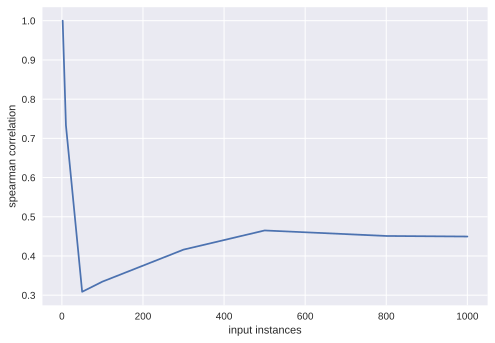

In [ ]:
plt.plot(xp, sp)
plt.xlabel("input instances")
plt.ylabel("spearman correlation")

In [ ]:
!pip install --quiet sentence_transformers

     |████████████████████████████████| 78 kB 3.5 MB/s 
     |████████████████████████████████| 3.4 MB 9.6 MB/s 
     |████████████████████████████████| 6.8 MB 33.3 MB/s 
     |████████████████████████████████| 61 kB 487 kB/s 
     |████████████████████████████████| 3.3 MB 49.3 MB/s 


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
pred_df.head()

,prediction,true,text,ans
0,What has Guinea-Bissau experienced since indep...,Guinea-Bissau has a history of what since inde...,Guinea-Bissau was once part of the kingdom of ...,political instability
1,What type of series-resonant circuit is ideal?,What could be the best possible output versus ...,The quarter-wave elements imitate a series-res...,lossless
2,The busiest station in New York is on the West...,In what borough is Pennsylvania Station located?,New York City's commuter rail network is the l...,Manhattan
3,"If a treaty is executed in multiple languages,...",What is the nature of the different versions o...,"The end of a treaty, the eschatocol (or closin...",equally authentic
4,Where was the first rock oil mine built?,Where was the first Rock Oil mine built?,The modern petroleum industry started in 1846 ...,Bóbrka


In [ ]:
sen_embeddings = model.encode([pred_df['prediction'][0], pred_df['true'][0]])
sen_embeddings.shape

(2, 768)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# cosine similarity for sentence 0:
cosine_similarity([sen_embeddings[0]], sen_embeddings[1:])[0][0]

0.939008

In [ ]:
xsim = list(range(1, 1001))
sim = []
for i in range(1000):
  sen_embeddings = model.encode([pred_df['prediction'][i], pred_df['true'][i]])
  sim.append(cosine_similarity([sen_embeddings[0]], sen_embeddings[1:])[0][0])

In [ ]:
print('SBERT similarity score: ', sum(sim)/len(sim))

SBERT similarity score:  0.7667477364987135


Text(0, 0.5, 'SBERT Similarity')

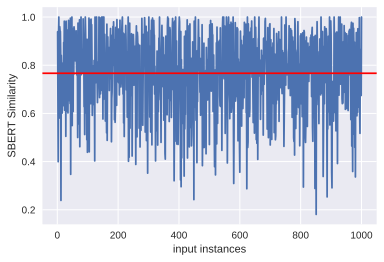

In [ ]:
plt.plot(xsim, sim)
plt.axhline(y=sum(sim)/len(sim), color='r', linestyle='-')
plt.xlabel("input instances")
plt.ylabel("SBERT Similarity")